# 2-population RNN (E-I cells)
Demo for implementation of 2-population E-I RNN obeying Dale's Law, such that 
- E neurons have only +ve outgoing synapses
- I neurons have only -ve outgoing synapses

Nov 6th, 2022

In [1]:
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import PIN_ntwk as pn
from utils import kth_diag_indices, generate_target_seq
import importlib
#importlib.reload(pn)

<module 'PIN_ntwk' from 'c:\\Users\\vyomr\\Downloads\\Code\\PINning\\PIN_ntwk.py'>

## Model params

In [2]:
N_E_neurons = 75
N_I_neurons = 75
N_E_silent = 0
N_neurons = N_E_neurons + N_I_neurons

# Neuron time constants -- how to get for E and I?
tau_neuron = 10*b2.ms

# Connection probabilities (Kosche 2015)
P_E_I_synapse = 34/43
P_I_E_synapse = 28/42
P_E_E_synapse = 1/140
# What about P_I_I ???

# Synaptic delays (Kosche 2015), 
# consider having heterogeneous delays with std distributions
delay_E_I = 0.43 * b2.ms
delay_I_E = 0.37 * b2.ms
delay_E_E = 1 * b2.ms

# Simulation params
duration = 5*b2.second
dt = 1*b2.ms
n_timesteps = int(duration/dt)

## Target sequence

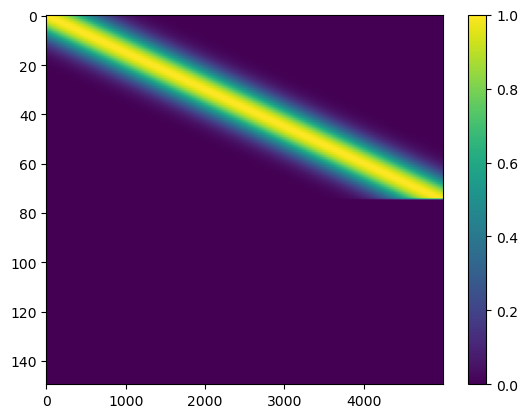

In [3]:
N_train_neurons = N_E_neurons - N_E_silent
arr_E_rates_ideal, _ = generate_target_seq(N_E_neurons - N_E_silent, n_timesteps, dt, std=0.3)

arr_target_fx = np.vstack((arr_E_rates_ideal, np.zeros((N_E_silent + N_I_neurons, 
                                                        n_timesteps))))
plt.imshow(arr_target_fx, aspect='auto')

plt.colorbar();

## Model

In [56]:
importlib.reload(pn)

c_net = pn.EI_ntwk(N_neurons=N_neurons,
                idx_E_neurons=np.arange(N_E_neurons),
                idx_I_neurons=np.arange(N_E_neurons, N_E_neurons+N_I_neurons),
                tau_neuron=tau_neuron, duration=duration, dt=dt, n_timesteps=n_timesteps, 
                g_wt_variance=1.35, theta=0, seed=42)
c_net.generate_frozen_external_input(tau_wn=1*b2.second, h0_wn=1)

#### Weight init

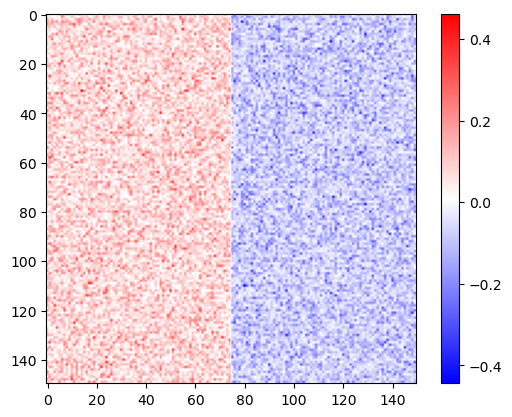

In [57]:
c_net.generate_weights()

plt.imshow(c_net.arr_J_init, cmap='bwr')
plt.colorbar()

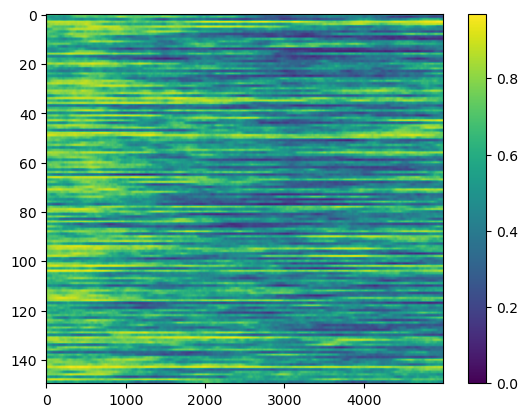

In [58]:
init_out = c_net.run(arr_target_fx, c_net.arr_J_init, rule='rate')

plt.imshow(init_out[1], aspect='auto')
plt.colorbar();

## Train

In [59]:
#wmax = c_net.g_wt_variance + 5/(np.sqrt(N_neurons))
wmax = 100
wmax

100

### With default parameters

100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


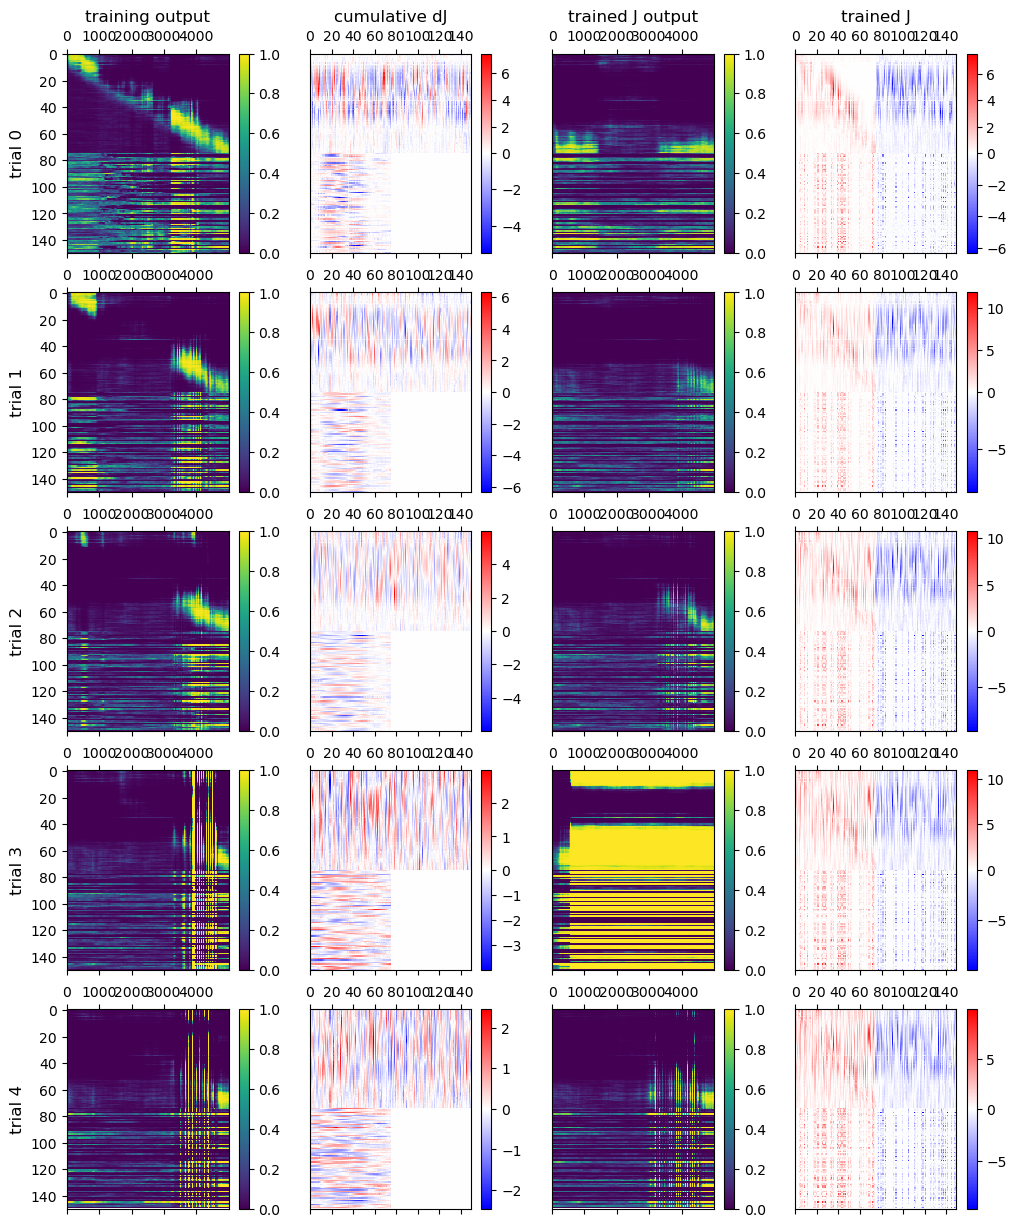

In [61]:
c_net.train(arr_target_fx, p_plastic=1, alpha=1, n_training_steps=5, n_plot_every=1,
            rule='rate', seed=0, b_inject_noise=False, amp_noise=1, wmax=wmax)

### Increasing alpha, which slows learning rate

100%|██████████| 5/5 [00:17<00:00,  3.48s/it]


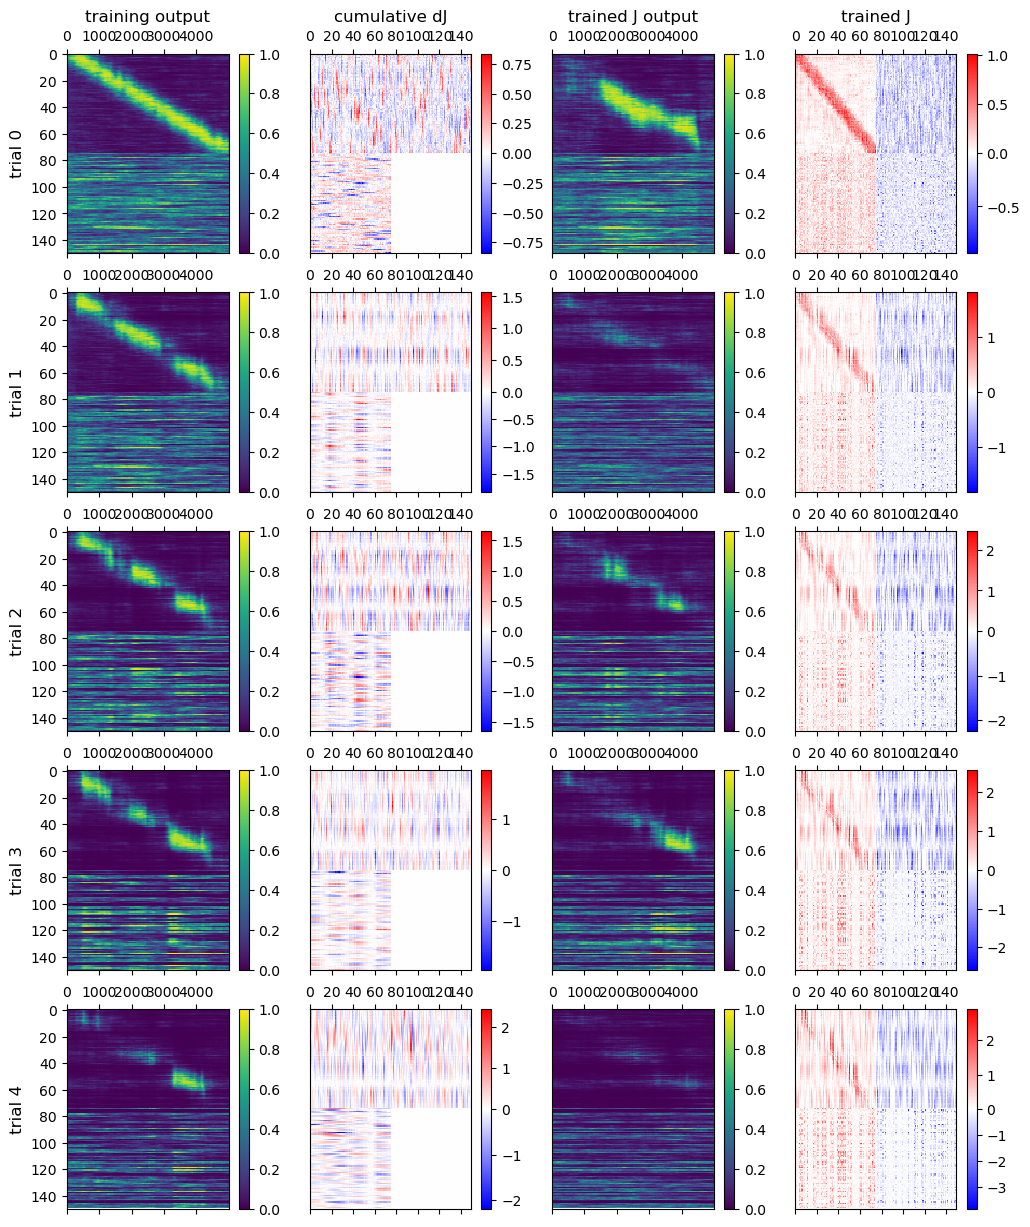

In [62]:
c_net.train(arr_target_fx, p_plastic=1, alpha=10, n_training_steps=5, n_plot_every=1,
            rule='rate', seed=0, b_inject_noise=False, amp_noise=1, wmax=wmax)

### Increasing alpha further

100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


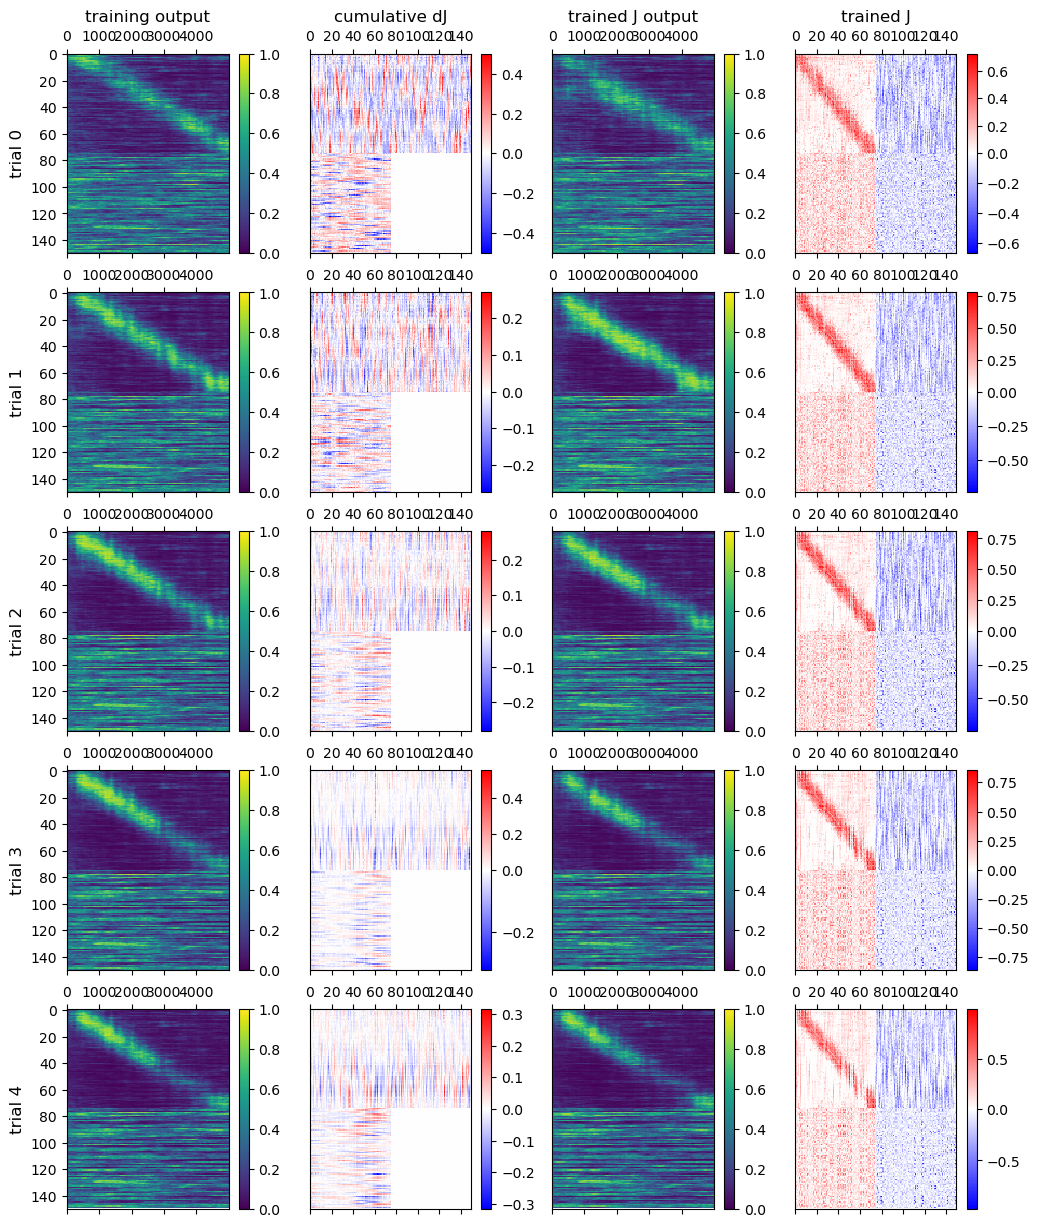

In [63]:
c_net.train(arr_target_fx, p_plastic=1, alpha=100, n_training_steps=5, n_plot_every=1,
            rule='rate', seed=0, b_inject_noise=False, amp_noise=1, wmax=wmax)

### Sequence fading with more training. Turning on noise.

100%|██████████| 5/5 [00:17<00:00,  3.51s/it]


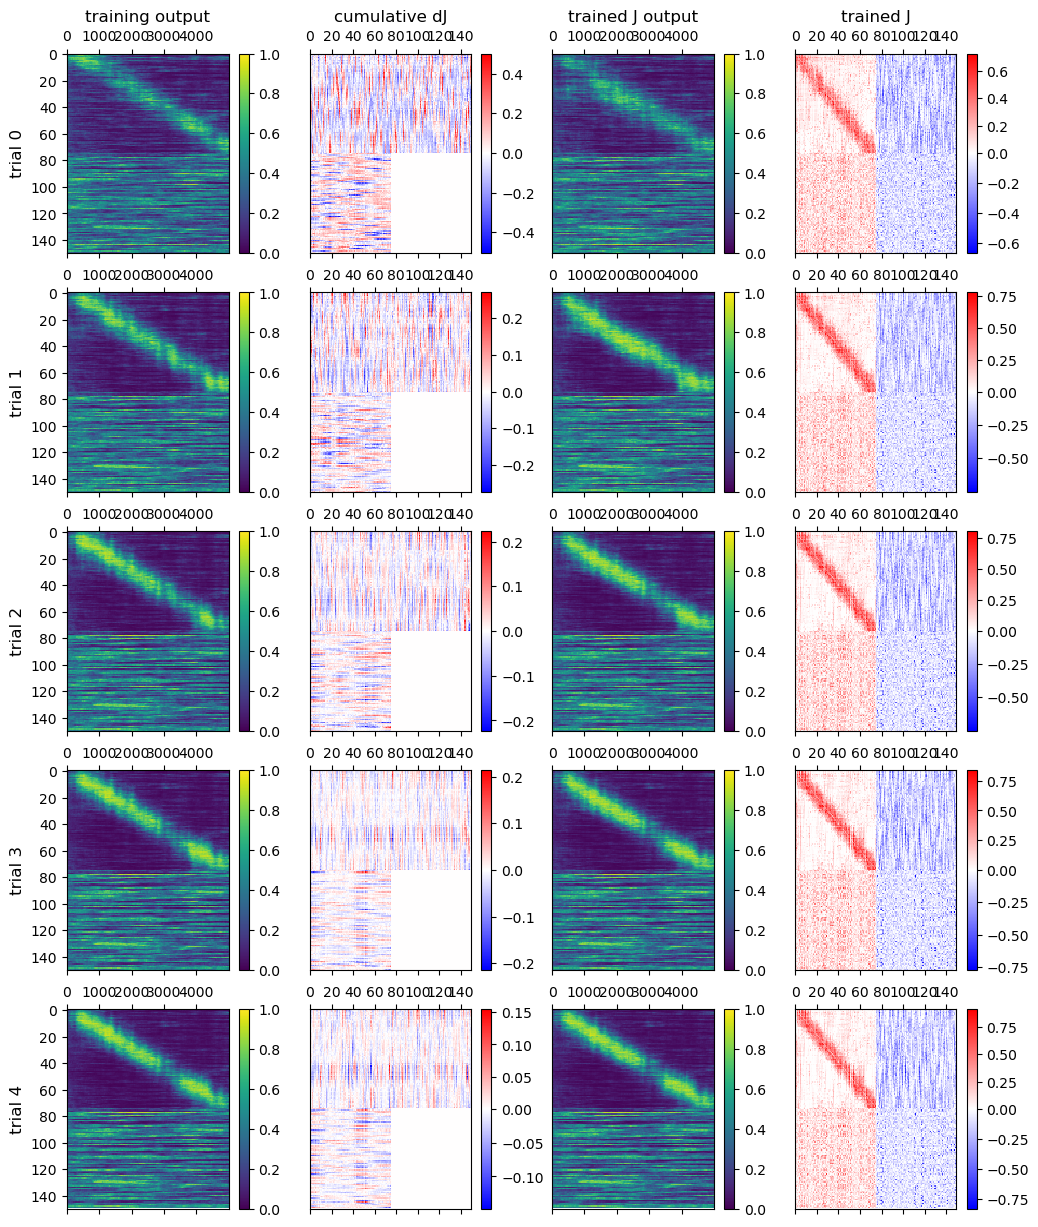

In [64]:
c_net.train(arr_target_fx, p_plastic=1, alpha=100, n_training_steps=5, n_plot_every=1,
            rule='rate', seed=0, b_inject_noise=True, amp_noise=1, wmax=wmax)

That improved training! Turning up noise further, slowing learning rate more, and training for longer

100%|██████████| 21/21 [01:03<00:00,  3.04s/it]


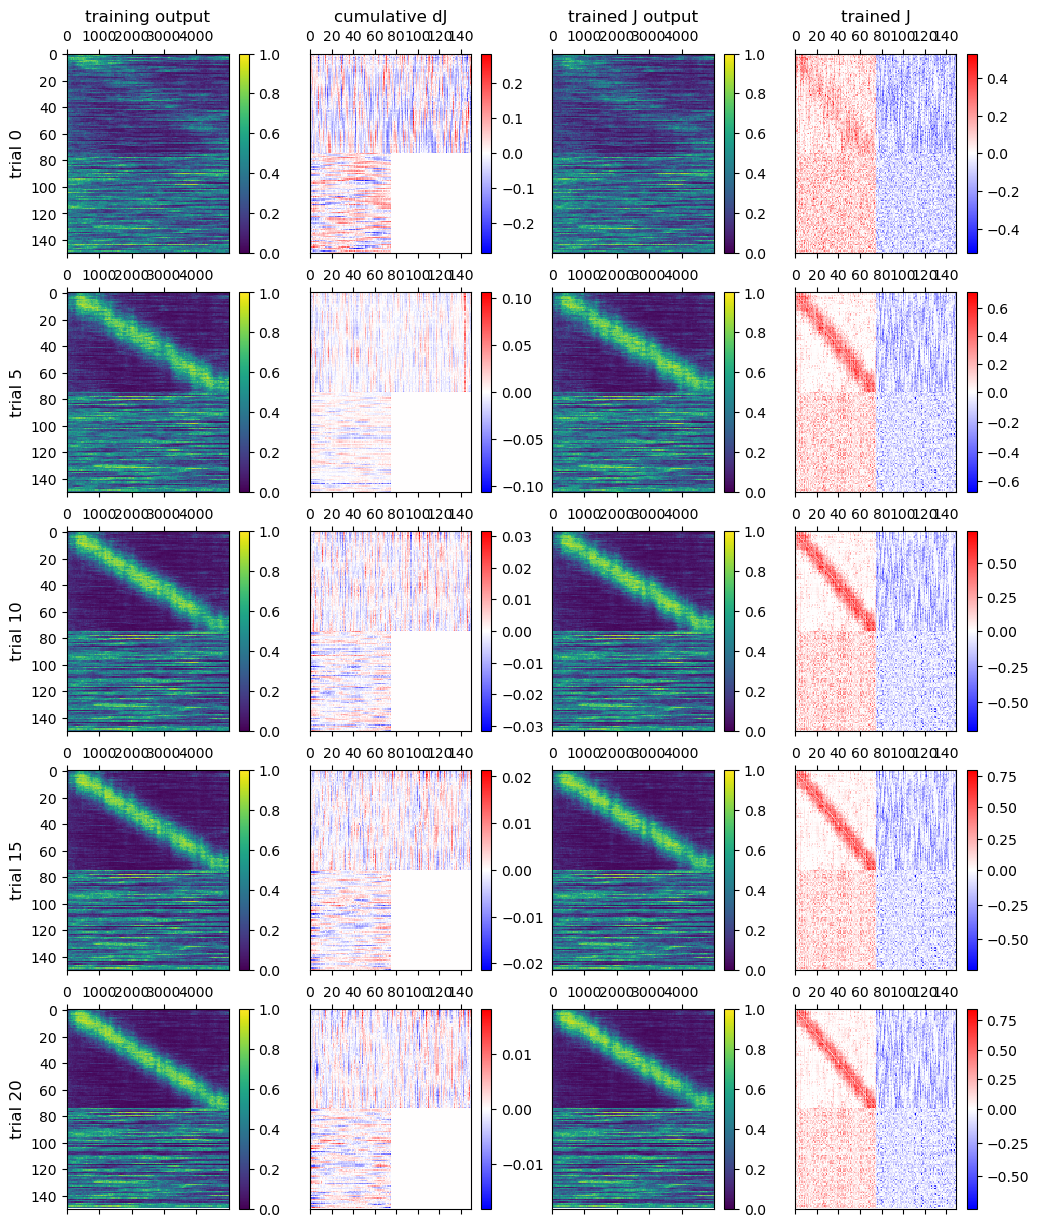

In [67]:
c_net.train(arr_target_fx, p_plastic=1, alpha=500, n_training_steps=21, n_plot_every=5,
            rule='rate', seed=0, b_inject_noise=True, amp_noise=2, wmax=wmax)

Performance

In [68]:
from utils import get_pvar

In [69]:
test_output = c_net.run(arr_target_fx, rule='rate', arr_J=c_net.arr_J_learned)
get_pvar(arr_E_rates_ideal, test_output[1][:N_E_neurons, :])

0.679422034905542

## Takeaways
Things that help E-I network learn sequence
- E->I updates according to -(transpose(I->E))
- Slower learning rate
- Higher noise amplitude
- More training steps

TODOs:
- examine I network activity and weight structure
- effect of restricting plastic synapses?
- alpha vs. performance
- noise vs. performance 
- other wt update rules